In [47]:
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import timm
import random
from sklearn.model_selection import train_test_split

import os
import cv2
from PIL import Image
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from skimage import io, transform
from skimage.transform import resize
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity


In [56]:
dir_names = os.listdir('./Cats_lapkins/')
dict1 = dict()
for i in dir_names:
    dict1[i]=os.listdir('./Cats_lapkins/'+i)
        
data = pd.DataFrame({'names':dict1.keys(), 'images':dict1.values()})
data

,names,images
0,Абиссинская кошка,"[Абиссинская кошка 1.jpg, Абиссинская кошка 10..."
1,Американская короткошерстная кошка,"[Американская короткошерстная кошка 1.jpg, Аме..."
2,Американский бобтейл,"[1.jpg, 2.jpg, 3.jpg, 4.jpg, 5.jpg, 6.jpg, Аме..."
3,Американский керл,"[Американский керл 1.jpg, Американский керл 10..."
4,Балинезийская кошка,"[Балинезийская кошка 1.jpg, Балинезийская кошк..."
...,...,...
57,Шотландская вислоухая кошка,"[Шотландская вислоухая кошка 1.jpg, Шотландска..."
58,Шотландская прямоухая кошка,"[Шотландская прямоухая кошка 1.jpg, Шотландска..."
59,Экзотическая кошка,"[Экзотическая кошка 1.jpg, Экзотическая кошка ..."
60,Эльф,"[Эльф 1.jpg, Эльф 10.jpg, Эльф 11.jpg, Эльф 12..."


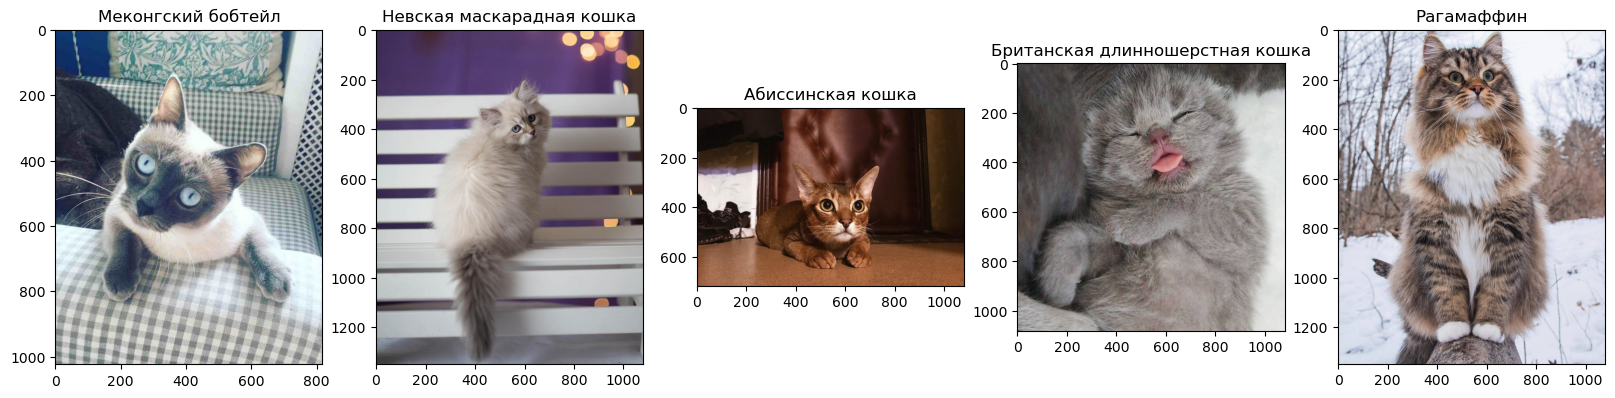

In [57]:
a = [list(dict1.keys())[i] for i in [np.random.randint(0,len(list(dict1.keys()))) for i in range(5)]]
s_names = ['./Cats_lapkins/'+i+'/'+dict1[i][np.random.randint(0,len(i))] for i in a]
imgs = []
for img in s_names:
    img = Image.open(img)
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

In [60]:
class CatsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_split_data(root_dir, train_size=0.75, val_size=0.15, test_size=0.1, seed=42):
    labels = os.listdir(root_dir)
    images = []
    image_labels = []

    for label in labels:
        label_dir = os.path.join(root_dir, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                images.append(os.path.join(label_dir, filename))
                image_labels.append(labels.index(label))

    train_images, test_images, train_labels, test_labels = train_test_split(
        images, image_labels, train_size=train_size + val_size, random_state=seed, stratify=image_labels)

    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, train_size=val_size / (test_size + val_size), random_state=seed, stratify=test_labels)

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [61]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_split_data('./Cats_lapkins/')

train_dataset = CatsDataset(train_images, train_labels, transform=transform)
val_dataset = CatsDataset(val_images, val_labels, transform=transform)
test_dataset = CatsDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
